<a href="https://colab.research.google.com/github/Hamdanarrosyid/AplikasiInputDataMahasiswa/blob/main/ingrediendt_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
!pip install --upgrade tensorflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.60.0 requires protobuf!=4.0.*,!=4.21.*,!=4.22.0,!=4.23.*,!=4.24.*,<4.26.0,>=3.20.3, but you have protobuf 5.28.3 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 5.28.3 which is incompatible.
tensorflow-text 2.15.0 requires tensorflow<2.16,>=2.15.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.18.0 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.18.0 which is incompatible.
tf-models-official 2.15.0 requires tensorflow~=2.15.0, but you have tensorflow 2.18.0 which is incompatible.


In [4]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

# Compile the Object Detection API protocol buffers and install the necessary packages
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Created wheel for object_detection: filename=object_detection-0.1-py3-none-any.whl size=1697353 sha256=d

In [1]:
!pip install protobuf==3.20 -q

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# import object detection api
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import colab_utils

# Utilitites

In [4]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """

    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """

    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)

    if image_name:
        plt.imsave(image_name, image_np_with_annotations)

    else:
        plt.imshow(image_np_with_annotations)


# Load dataset

In [5]:
!pip install roboflow -q


In [6]:
!rm -rf FOOD-INGREDIENTS-dataset-4
from roboflow import Roboflow

rf = Roboflow(api_key="lQr15x1tN1apGpIqEmra")
project = rf.workspace("food-recipe-ingredient-images-0gnku").project("food-ingredients-dataset")
version = project.version(4)
dataset = version.download("tensorflow",location='dataset')

loading Roboflow workspace...
loading Roboflow project...


In [7]:
TRAIN_ANNOTATION_PATH = './dataset/train/_annotations.csv'
TRAIN_PATH = './dataset/train'
TEST_PATH = './dataset/test'
TEST_ANNOTATION_PATH = './dataset/test/_annotations.csv'
VALID_PATH = './dataset/valid'
VALID_ANNOTATION_PATH = './dataset/valid/_annotations.csv'

In [8]:
import pandas as pd

df = pd.read_csv(TRAIN_ANNOTATION_PATH)
df.describe()

,width,height,xmin,ymin,xmax,ymax
count,19488.0,19488.0,19488.000000,19488.000000,19488.000000,19488.000000
mean,640.0,640.0,185.897116,173.312757,455.552853,466.941297
std,0.0,0.0,143.724299,134.729093,144.650546,136.559163
min,640.0,640.0,0.000000,0.000000,36.000000,14.000000
25%,640.0,640.0,60.000000,60.000000,342.000000,366.000000
50%,640.0,640.0,157.000000,145.000000,485.000000,498.000000
75%,640.0,640.0,297.000000,271.000000,581.000000,583.000000
max,640.0,640.0,604.000000,626.000000,640.000000,640.000000


In [9]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,download-1-_jpg.rf.00018808842c2f521772e83f35a...,640,640,Bethu ko Saag,61,114,561,548
1,download_jpg.rf.0008224bb54982df22e1468a118651...,640,640,Bitter Gourd,183,66,640,307
2,download_jpg.rf.0008224bb54982df22e1468a118651...,640,640,Bitter Gourd,1,197,491,563
3,download_jpg.rf.0008224bb54982df22e1468a118651...,640,640,Bitter Gourd,113,105,533,554
4,364358893_990569905513546_1245418979220757951_...,640,640,Chili Pepper -Khursani-,213,90,549,481


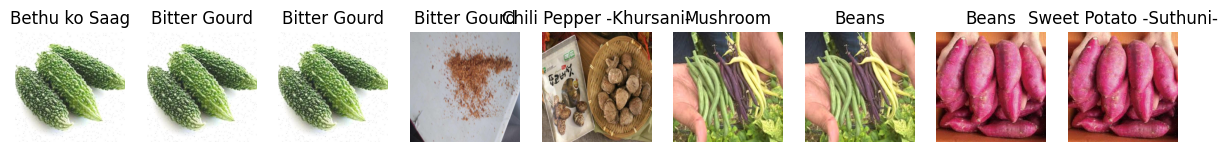

In [10]:
# Visualize train image
%matplotlib inline
fig = plt.figure(figsize=(15,10))
end_idx = 10

temp_images_np = []
for i in range(1, end_idx):
    image_path = os.path.join(TRAIN_PATH, df.iloc[i]['filename'])
    temp_images_np.append(load_image_into_numpy_array(image_path))

for idx, image_np in enumerate(temp_images_np):
    ax = fig.add_subplot(1, end_idx - 1, idx+1)
    ax.imshow(image_np)
    ax.set_title(df.iloc[idx]['class'])
    ax.axis('off')

# Preprocessing

In [11]:
def create_category_index(csv_file):
  df = pd.read_csv(csv_file)
  class_name = df['class'].unique()
  category_index = {}
  for i, name in enumerate(class_name):
    category_index[i+1] = {'id': i+1, 'name': name}
  return category_index

def parse_annotations(csv_file, images_dir, category_index):
    name_to_id = {item['name']: item['id'] for item in category_index.values()}
    df = pd.read_csv(csv_file)

    data = []
    for _, row in df.iterrows():
        if row['class'] not in name_to_id:
          continue
        image_path = os.path.join(images_dir, row['filename'])
        # Normalize bounding boxes to [0, 1]
        gt_boxes = np.array([
            [row['xmin'] / row['width'],
             row['ymin'] / row['height'],
             row['xmax'] / row['width'],
             row['ymax'] / row['height']]
        ], dtype=np.float32)
        class_id = name_to_id[row['class']]
        data.append((image_path, gt_boxes, class_id))
    return data

def create_tf_dataset(data, category_index):

  dataset = tf.data.Dataset.from_generator(
      lambda: iter(data),
      output_types=(tf.string, tf.float32, tf.int32),
  )

  def preprocess(iamge_path, gt_boxes, class_id):
    image = tf.io.read_file(iamge_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.expand_dims(image, axis=0)
    gt_boxes = tf.convert_to_tensor(gt_boxes, dtype=tf.float32)

    num_boxes = tf.shape(gt_boxes)[0]
    zero_indexed_groundtruth_classes = tf.ones(shape=[num_boxes], dtype=tf.float32) - 1

    # Cast to int32 for one_hot encoding
    zero_indexed_groundtruth_classes = tf.cast(zero_indexed_groundtruth_classes, dtype=tf.int32)

    gt_classes = tf.one_hot(zero_indexed_groundtruth_classes, depth=len(category_index))
    return image, gt_boxes, gt_classes

  dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
  return dataset




In [12]:
#  processing dataset
print("[INFO] Processing dataset")

category_index = create_category_index(TRAIN_ANNOTATION_PATH)
train_data = parse_annotations(TRAIN_ANNOTATION_PATH, TRAIN_PATH, category_index)
test_data = parse_annotations(TEST_ANNOTATION_PATH, TEST_PATH, category_index)
valid_data = parse_annotations(VALID_ANNOTATION_PATH, VALID_PATH, category_index)

train_dataset = create_tf_dataset(train_data, category_index)
test_dataset = create_tf_dataset(test_data, category_index)
valid_dataset = create_tf_dataset(valid_data, category_index)
num_classes = len(category_index)

print("[INFO] Done")






[INFO] Processing dataset
[INFO] Done


In [13]:
for images, gt_boxes, gt_classes in train_dataset.take(1):
    print(images.shape)
    print(gt_boxes)
    print(gt_classes)

(1, 640, 640, 3)
tf.Tensor([[0.0953125 0.178125  0.8765625 0.85625  ]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 115), dtype=float32)


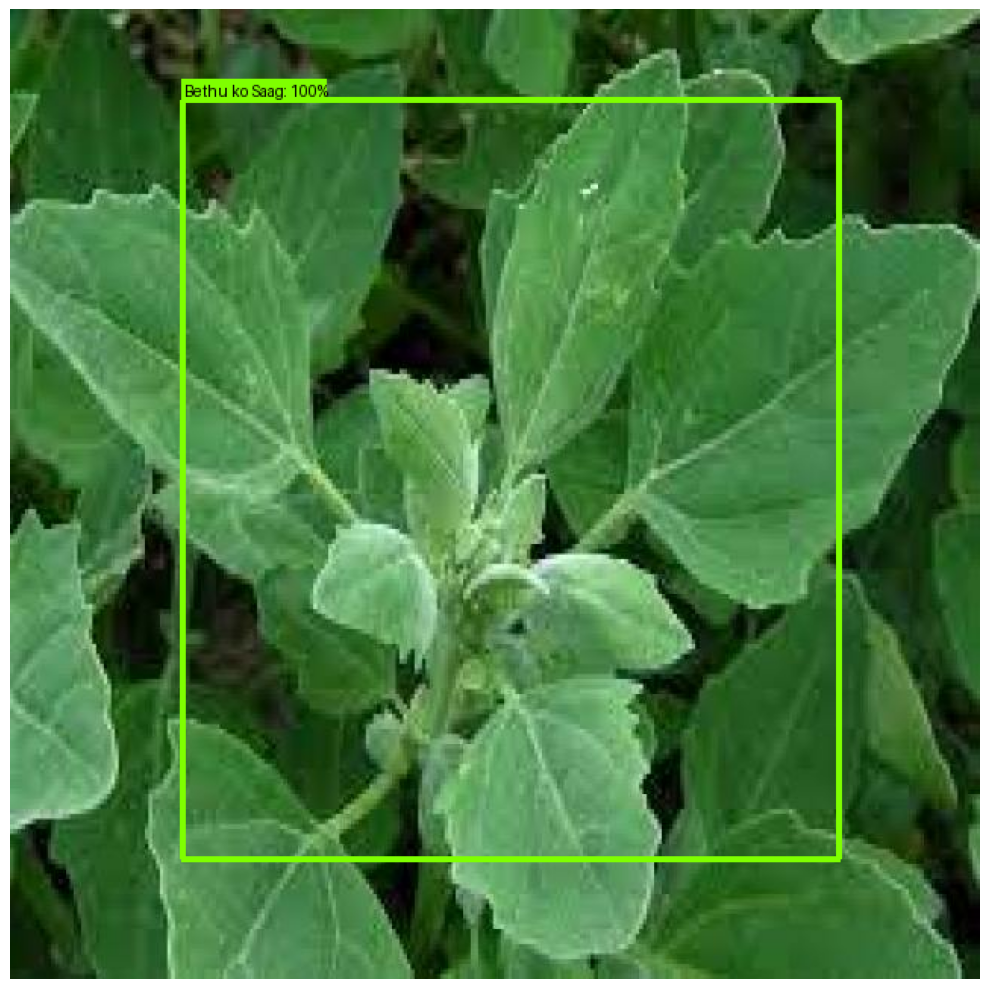

In [14]:
# inspect
dummy_scores = np.array([1, 0], dtype=np.float32)

plt.figure(figsize=(10, 10))
for i, (images, gt_boxes, gt_classes) in enumerate(train_dataset.take(1)):
    plt.subplot(1, 1, i + 1)

    image = images.numpy()
    gt_boxes = gt_boxes.numpy()
    gt_classes = gt_classes.numpy()

    # Call your custom plotting function
    plot_detections(
        image[0],
        gt_boxes,
        np.ones(shape=[gt_classes.shape[0]], dtype=np.int32),
        dummy_scores,
        category_index,
    )

    plt.axis("off")  # Hide axis for a cleaner visualization

plt.tight_layout()
plt.show()

# Download checkpoints

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

# Configure the model

In [15]:
tf.keras.backend.clear_session()

pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
model_config

ssd {
  num_classes: 115
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: 

In [16]:
# build the custom model

detection_model = model_builder.build(model_config, is_training=True)
print(type(detection_model))
vars(detection_model)

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 4, <_ObjectIdentityWrapper wrapping 115>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({})>: 1, <_ObjectIdentityWrapper wrapping True>: 7, <_ObjectIdentityWrapper wrapping <object_detection.anchor_generators.multiscale_grid_anchor_generator.MultiscaleGridAnchorGenerator object at 0x7b0a77eb6890>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor object at 0x7b0a77f2c3a0>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.box_coders.faster_rcnn_box_coder.FasterRcnnBoxCoder object at 0x7b0a77161de0>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7b0a77f2f1f0>>: 1, <_ObjectIdentityWrapper wrapping 'ResNet50V1_FPN'>: 1, <_ObjectIdentityWrapper wrapping <tf.Tens

In [17]:
vars(detection_model._box_predictor)

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 5, <_ObjectIdentityWrapper wrapping True>: 3, <_ObjectIdentityWrapper wrapping 115>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7b0a77eb4af0>>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({'class_predictions_with_background': <object_detection.predictors.heads.keras_class_head.WeightSharedConvolutionalClassHead object at 0x7b0a77eb5600>})>: 1, <_ObjectIdentityWrapper wrapping ListWrapper(['class_predictions_with_background'])>: 1, <_ObjectIdentityWrapper wrapping <object_detection.builders.hyperparams_builder.KerasLayerHyperparams object at 0x7b0a77eb6aa0>>: 1, <_ObjectIdentityWrapper wrapping 256>: 1, <_ObjectIdentityWrapper wrapping 4>: 1, <_ObjectIdentityWrapper wrapping 3>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([])>: 1, <_ObjectIdentityWrapper wrapping 

In [18]:
temp_box_prediction_checkpoint = tf.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head = detection_model._box_predictor._box_prediction_head
)

temp_model_checkpoint = tf.train.Checkpoint(
    _feature_extractor = detection_model._feature_extractor,
    _box_predictor = temp_box_prediction_checkpoint
)
vars(temp_model_checkpoint)

{'_root': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_box_predictor, ref=<tensorflow.python.checkpoint.checkpoint.Checkpoint object at 0x7b0a77f2f790>),
  TrackableReference(name=_feature_extractor, ref=<object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7b0a77f2f1f0>)],
 '_self_unconditional_dependency_names': {'_box_predictor': <tensorflow.python.checkpoint.checkpoint.Checkpoint at 0x7b0a77f2f790>,
  '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7b0a77f2f1f0>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_kwargs': {'_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7b0a77f2f1f0>,


In [19]:
# Restore checkpoint
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

checkpoint = tf.train.Checkpoint(
    model = temp_model_checkpoint
)

checkpoint.restore(checkpoint_path)

In [20]:
# dummy image
temp_image, temp_shape = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
temp_prediction_dict = detection_model.predict(temp_image, temp_shape)
temp_detection = detection_model.postprocess(temp_prediction_dict, temp_shape)
print('Weights restored')

Weights restored


In [21]:
print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


# Eager mode custom training loop

In [22]:
tf.keras.backend.set_learning_phase(True)

batch_size = 32
num_batches = 100

learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [23]:
# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 696) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(696,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_

In [24]:
# define a list that contains the layers that you wish to fine tune
to_fine_tune = []

for v in detection_model.trainable_variables:
    if v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutional'):
        to_fine_tune.append(v)

for v in to_fine_tune:
    print(v.name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0


In [25]:
# try one training
sample_train = train_dataset.take(2)
element = next(iter(sample_train.as_numpy_iterator()))

image_tensor = tf.convert_to_tensor(element[0], dtype=tf.float32)
print(image_tensor.shape)

g_preprocessed_image = detection_model.preprocess(image_tensor)
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")


(1, 640, 640, 3)
g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


In [26]:
preprocessed_image_list = []
true_shape_list = []
gt_boxes_list = []
gt_classes_list = []

for img, bxs , cls in sample_train:
  img_tensor = tf.cast(img, dtype=tf.float32)
  preprocessed_image, true_shape = detection_model.preprocess(img_tensor)
  preprocessed_image_list.append(preprocessed_image)
  true_shape_list.append(true_shape)

  gt_boxes_list.append(bxs)
  gt_classes_list.append(cls)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")


preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


In [27]:
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(preprocessed_image_tensor.shape)
print(true_shape_tensor.shape)

(2, 640, 640, 3)
(2, 3)


In [28]:
# make prediction
try:
    prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)
except AttributeError as e:
    print("Error message:", e)

In [29]:
# get ground truth bounding box
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [30]:
# Calculate the loss after you've provided the ground truth
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.52887958
classification loss 1.48666823


In [31]:
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    with tf.GradientTape() as tape:
        preprocessed_image_tensor = tf.concat([model.preprocess(ig)[0] for ig in image_list], axis=0)
        true_shape_tensor = tf.concat([model.preprocess(ig)[1] for ig in image_list], axis=0)

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Calculate the total loss (sum of both losses)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list
        )


        loss_dict = model.loss(prediction_dict, true_shape_tensor)


        total_loss = loss_dict['Loss/localization_loss'] + loss_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))


    return total_loss

In [32]:

all_keys = list(range(len(train_data)))
random.shuffle(all_keys)
example_keys = all_keys[:batch_size]

img_tensors = []
gt_boxes_list = []
gt_classes_list = []
for idx, (image_np, bounding_boxes, class_id) in enumerate(train_dataset):
    if idx in example_keys:
        gt_boxes_list.append(bounding_boxes)
        gt_classes_list.append(class_id)
        imgtnsr = tf.convert_to_tensor(image_np, dtype=tf.uint8)
        imgtnsr = tf.cast(image_tensor, dtype=tf.float32)
        img_tensors.append(imgtnsr)


In [33]:
# print(type(img_tensors[0]))
detection_model.preprocess(img_tensors[1])[1]


<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[640, 640,   3]], dtype=int32)>

In [ ]:
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  total_loss = train_step_fn(img_tensors,
                               gt_boxes_list,
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

  if idx % 10 == 0:
      print('batch ' + str(idx) + ' of ' + str(num_batches)
      + ', loss=' +  str(total_loss.numpy()), flush=True)


print('Done fine-tuning!')

Start fine-tuning!
